# Urban area mapping using Sentinel 1 data

* **Products used:** 
[s1_rtc](https://explorer.digitalearth.africa/products/s1_rtc), 

## Background

Urban areas account for a small proportion of global land cover, but support daily human life and exert a great influence on environmental and ecological changes [Xia et al. 2019](https://doi.org/10.3390/rs11121470). 
This means that constant monitoring of the built environment is crucial for sustainable development. 
There are different techniques used to classify urban areas using both optical and radar data, one of the simplest is Kmeans clustering (unsupervised machine learning). 

While urban areas can be mapped using optical data, the image quality is strongly affected by weather conditions such as cloud cover. 
This limits the temporal avaliability of clear images in tropical areas that experience very cloudy weather and heavy rains. 
The image quality of radar data is independent of daylight and weather conditions, which makes it more suitable for urban area mapping. 
For more information, see the [Sentinel-1](../Datasets/Sentinel_1.ipynb) notebook.

## Description

This notebook uses Kmeans Clustering to classify land as 'urban' then compares those results with the ESA WorldCover global land cover product for the year 2020.

The choice of the number of clusters to use for the Kmeans Clustering and the pixel value that represents the urban land cover class can be informed by comparing the prediction images with the "ground truth" dataset.

This notebook contains the following steps:

1. Select a location and time range  for the analysis.
2. Load Sentinel-1 backscatter data for the area of interest. 
3. Convert the digital numbers to dB values for analysis.
4. Generate a median VH and VV polarization composite image from the Sentinel 1 data.
5. Perform Kmeans Clustering on the median composite image. 
6. Show the Kmeans Clustering urbanization prediction image.
7. Load and show the "ground truth" ESA Worldcover data for the year 2020.
8. Compare the urbanization prediction with the "ground truth" data visually and statistically.

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import the Python packages that are used for the analysis.

In [1]:
# Load the necessary Python packages.
%matplotlib inline

import warnings
import datacube
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolours
from matplotlib.patches import Patch

warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)

from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map, plot_lulc
from deafrica_tools.classification import sklearn_flatten, sklearn_unflatten
from deafrica_tools.dask import create_local_dask_cluster

## Set up a Dask cluster

Dask can be used to better manage memory use down and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:44743 Dashboard: /user/eefaye.chong/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 13.11 GB


### Connect to the datacube

Connect to the datacube so we can access the Digital Earth Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [3]:
dc = datacube.Datacube(app="Urban_area_mapping")

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis.
The parameters are:
* `central_lat`: The central latitude of the area of interest to analyse.
* `central_lon`: The central longitude of the area of interest to analyse.
* `buffer`: The number of square degrees to load around the central latitude and longitude. 
For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The time range for your analysis, e.g.`('2020')` if you wanted data from all of the year 2020.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers part of  Nairobi County, Kenya.

In [4]:
# Define the area of interest.
central_lat = -1.2933
central_lon =  36.8379

lat_buffer = 0.1
lon_buffer = 0.1

# Combine lat, lon with their respective buffers to get area of interest.
lat_range = (central_lat - lat_buffer, central_lat + lat_buffer)
lon_range = (central_lon - lon_buffer, central_lon + lon_buffer)

# Time frame for the analysis.
time_range = ("2020-01", "2020-04")

### View the selected location

The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [5]:
# View the study area
display_map(x=lon_range, y=lat_range)

## Load and view the Sentinel-1 data

### Create a datacube query object
We will create a dictionary that will contain the parameters that will be used to load the Sentinel 1 data from the Digital Earth Africa datacube.

In [6]:
query = {
    "y": lat_range,
    "x": lon_range,
    "time": time_range,
    "output_crs": "EPSG:6933",
    "resolution": (-20, 20),
    "dask_chunks":dict(x=1000,y=1000)
}

print(query)

{'y': (-1.3933, -1.1932999999999998), 'x': (36.737899999999996, 36.9379), 'time': ('2020-01', '2020-04'), 'output_crs': 'EPSG:6933', 'resolution': (-20, 20), 'dask_chunks': {'x': 1000, 'y': 1000}}


### Load the Sentinel 1 data
The first step in the analysis is to load Sentinel-1 backscatter data for the specified area of interest.
This uses the pre-defined [load_ard](../Frequently_used_code/Using_load_ard.ipynb) utility function. 
The `load_ard` function is used here to load an analysis ready dataset free of shadow, and missing data.

In [7]:
ds = load_ard(
    dc=dc, products=["s1_rtc"], measurements=["vv", "vh"], group_by="solar_day", **query
)

print(ds)

Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 30 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 30, y: 1276, x: 965)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-04T15:56:20.113636 ... 2020-04...
  * y            (y) float64 -1.522e+05 -1.522e+05 ... -1.777e+05 -1.777e+05
  * x            (x) float64 3.545e+06 3.545e+06 ... 3.564e+06 3.564e+06
    spatial_ref  int32 6933
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 1000, 965), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 1000, 965), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


## Convert the Digital Number (DN) values to Decibel values (dB)

The Sentinel-1 backscatter data is provided as digital number (DN), which can be converted to backscatter in decibel unit (dB) using the function:

\begin{equation}
10 * \log_{10}\left(\text{DN} \right)
\end{equation}


It is often useful to convert the backscatter to decible (dB) for analysis because the backscatter in dB unit has a more symmetric noise profile and less skewed value distribution for easier statistical evaluation.

In [8]:
# Convert DN to db values.
ds["vv"] = 10 * xr.ufuncs.log10(ds.vv)
ds["vh"] = 10 * xr.ufuncs.log10(ds.vh)

### View the Sentinel 1 data

CPLReleaseMutex: Error = 1 (Operation not permitted)


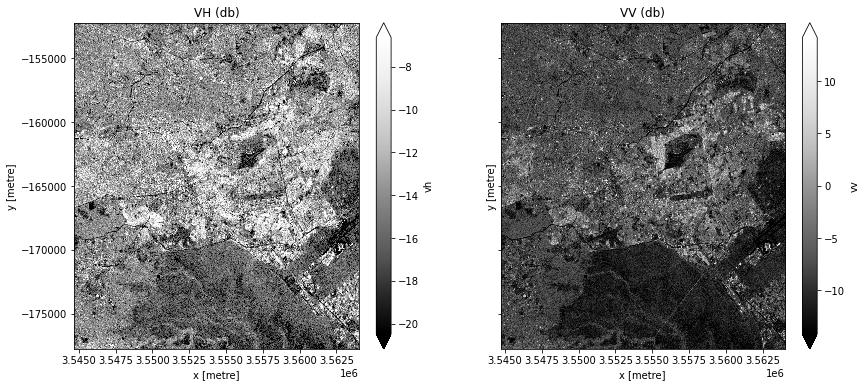

In [9]:
# Plot the first VH and VV observation for the year 2020.
fig,ax=plt.subplots(1,2, figsize=(14, 6), sharey=True)
ds.vh.isel(time=0).plot.imshow(cmap="Greys_r", robust=True, ax=ax[0])
ds.vv.isel(time=0).plot.imshow(cmap="Greys_r", robust=True, ax=ax[1])
ax[0].set_title('VH (db)')
ax[1].set_title('VV (db)');

## Generate a median value composite image
We will combine all the VH and VV observations in our Sentinel 1 `ds` `xarray.Dataset` into a single, complete (or near complete) image representing the median of the time period.

Note, here we will `.compute()` the median, which will bring our data into memory. This will take a couple of minutes to run.

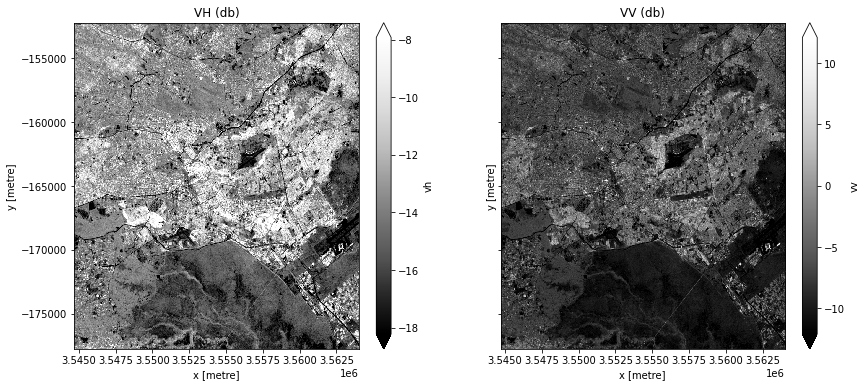

In [10]:
# Obtain the median of all VH and VV observations for the time period.
ds = ds.median(dim="time").compute()

fig,ax=plt.subplots(1,2, figsize=(14, 6), sharey=True)
ds.vh.plot.imshow(cmap="Greys_r", robust=True, ax=ax[0])
ds.vv.plot.imshow(cmap="Greys_r", robust=True, ax=ax[1])
ax[0].set_title('VH (db)')
ax[1].set_title('VV (db)');

## Classification using Kmeans Clustering

In the next cell we will create a set of functions which will together be used to perform Kmeans Clustering on our median value composite image. 
This functions are adapted from the ones used [here](https://ml-gis-service.com/index.php/2020/10/14/data-science-unsupervised-classification-of-satellite-images-with-k-means-algorithm/).

In [11]:
# Defining functions to use for the Kmeans clustering.
def show_clustered(predicted_ds):
    """
    Takes the predicted xarray DataArray and plots it.

    Last modified: November 2021
    Parameters
    ----------
    predicted_ds : xarray DataArrray
    The xarray DataArray which is the result of the kmeans clustering.

    Returns
    -------
    An plot of the predicted_ds.
    """

    # Display predicted_ds Dataset with upto 6 unique classes.
    image = predicted_ds

    # Color list with 6 colors from the virdis color map.
    no_classes = len(np.unique(image))
    colour_list = ["#fde725", "#440154", "#22a884", "#414487", "#2a788e", "#7ad151"]
    colours = colour_list[:no_classes]
    cmap = mcolours.ListedColormap(colours)
    bounds = range(0, no_classes + 1)
    norm = mcolours.BoundaryNorm(np.array(bounds), cmap.N)
    cblabels = [str(i) for i in bounds]
    im = image.plot.imshow(cmap=cmap, norm=norm, add_colorbar=True, figsize=(6, 6))
    cb = im.colorbar
    cb.set_ticks(np.arange(0, no_classes + 1, 1) + 0.5)
    cb.set_ticklabels(cblabels)
    plt.axis("off")
    title = f"Kmeans Clustering Predicted Image using {no_classes} clusters"
    plt.title(title)
    plt.show()


def kmeans_clustering(input_xr, cluster_range):
    """
    Perform sklearn Kmeans clustering on the input Dataset
    or Data Array.

    Last modified: November 2021

    Parameters
    ----------
    input_xr : xarray.DataArray or xarray.Dataset
        Must have dimensions 'x' and 'y', may have dimension 'time'.

    cluster_range : list
        A list of the number of clusters to use to perform the Kmeans clustering
        on the input_xr Dataset.

    Returns
    ----------
    results : dictionary
        A dictionary with the number of clusters as keys and the predicted xarray.DataArrays
        as the values. Each predicted xarray.DataArray has the same dimensions 'x', 'y' and
        'time' as the input_xr.

    """

    # Use the sklearn_flatten function to convert the Dataset or DataArray into a 2 dimensional numpy array.
    model_input = sklearn_flatten(input_xr)

    # Standardize the data.
    scaler = StandardScaler()
    model_input = scaler.fit_transform(model_input)

    # Dictionary to save results
    results = {}

    # Perform Kmeans clustering on the input dataset for each number of clusters
    # in the cluster_range list.
    for no_of_clusters in cluster_range:
        # Set up the kmeans classification by specifying the number of clusters
        # with initialization as k-means++.
        km = KMeans(n_clusters=no_of_clusters, init="k-means++", random_state=1)

        # Begin iteratively computing the position of the clusters.
        km.fit(model_input)

        # Use the sklearn kmeans .predict method to assign all the pixels of the
        # model input to a unique cluster.
        flat_predictions = km.predict(model_input)

        # Use the sklearn_unflatten function to convert the flat predictions into a
        # xarray DataArray.
        predicted = sklearn_unflatten(flat_predictions, input_xr)
        predicted = predicted.transpose("y", "x")

        # Append the results to a dictionary using the number of clusters as the
        # column as an key.
        results.update({str(no_of_clusters): predicted})

    return results

In the next cell, we will use a range of clusters to perform  K-means classification on our median composite dataset.

Below, **enter a list of bands to include in the classification**

In [12]:
bands=['vv']

Now we will run the Kmeans classification, and then plot the results

In [13]:
cluster_range = [2, 3, 4]
results = kmeans_clustering(ds[bands], cluster_range)

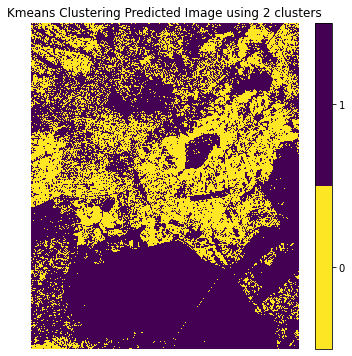

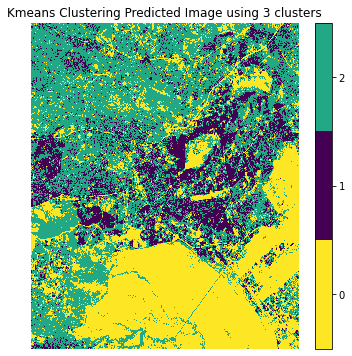

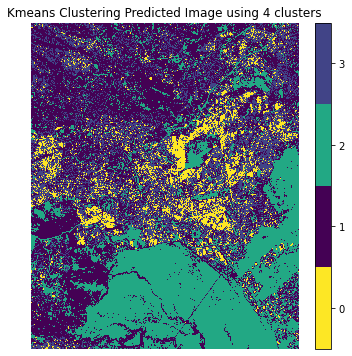

In [14]:
# Plot each of the predicted images.
for predicted_ds in results.values():
    show_clustered(predicted_ds)

## Decide which model and class to assign as 'urban'

From the plotted predicted images above the best number of clusters to use is `3` clusters. 
In this image, the most likely pixel value to represent the urban/buit up land cover class is the pixel value `1`. 

> Note: this may change depending on the area of interest and number of clusters used. In this example, the initial state has been arbitrarily defined using the `random_state` argument in the `kmeans_clustering` function.

Set the `key` and the `pixel_value` representing the model and value, respectively, that you want to assign as urban areas

In [15]:
# Mask the dataset to retain the pixels which are most likely to be urban/built up.
key = "3"
pixel_value = 1

clustering_predicted_ds = results[key] == pixel_value
print(clustering_predicted_ds)

<xarray.DataArray (y: 1276, x: 965)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False,  True],
       [ True,  True,  True, ..., False, False, False],
       [False,  True,  True, ..., False, False, False]])
Coordinates:
  * x        (x) float64 3.545e+06 3.545e+06 3.545e+06 ... 3.564e+06 3.564e+06
  * y        (y) float64 -1.522e+05 -1.522e+05 ... -1.777e+05 -1.777e+05


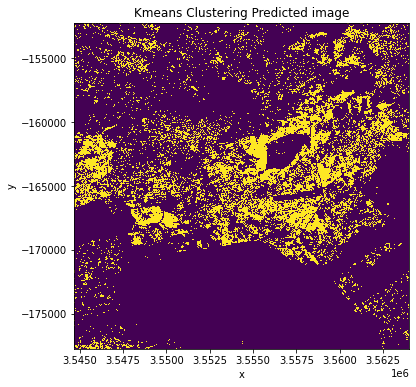

In [16]:
clustering_predicted_ds.plot.imshow(figsize=(6,6), add_colorbar=False)
plt.title("Kmeans Clustering Predicted image");

## Validation of the Kmeans Clustering classification
We will compare the performance of the urban area Kmeans clustering classification result against a built area (urban area) map for the study area derived from the ESA World Cover, global 10 m land use/land cover data from 2020. 

### Obtain the validation dataset

In [17]:
# Load the ESA land use land cover product over the same region as the Sentinel 1 dataset.
ds_esa = dc.load(product="esa_worldcover", like=ds.geobox).squeeze()

print(ds_esa)

<xarray.Dataset>
Dimensions:         (y: 1276, x: 965)
Coordinates:
    time            datetime64[ns] 2020-07-01T12:00:00
  * y               (y) float64 -1.522e+05 -1.522e+05 ... -1.777e+05 -1.777e+05
  * x               (x) float64 3.545e+06 3.545e+06 ... 3.564e+06 3.564e+06
    spatial_ref     int32 6933
Data variables:
    classification  (y, x) uint8 10 10 10 10 10 10 10 ... 30 60 50 60 60 60 60
Attributes:
    crs:           PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 Global",GEOGCS["WGS 8...
    grid_mapping:  spatial_ref


### Plot the ESA land use land cover product.

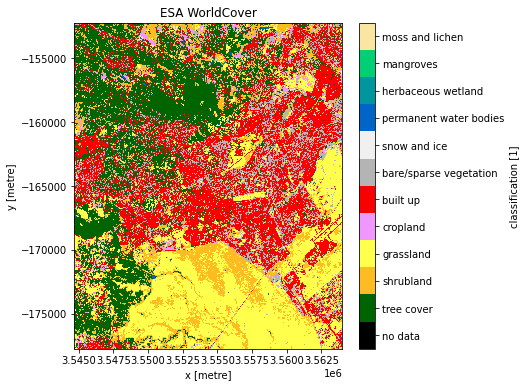

In [18]:
# Plot the ESA land use land cover product.
fig, ax = plt.subplots(figsize=(6, 6), sharey=True)
plot_lulc(ds_esa["classification"], product="ESA", legend=True, ax=ax)
plt.title("ESA WorldCover");

We're only interested in the built-up areas, so we can use the flags definition on the dataset to isolate just the `built-up` class

In [19]:
ds_esa.classification.attrs['flags_definition']

{'data': {'bits': [0, 1, 2, 3, 4, 5, 6, 7],
  'values': {'0': 'no data',
   '10': 'tree cover',
   '20': 'shrubland',
   '30': 'grassland',
   '40': 'cropland',
   '50': 'built up',
   '60': 'bare/sparse vegetation',
   '70': 'snow and ice',
   '80': 'permanent water bodies',
   '90': 'herbaceous wetland',
   '95': 'mangroves',
   '100': 'moss and lichen'},
  'description': 'Land Use/Land Cover class'}}

### Plot the ESA urban areas alongside the Kmeans estimate from S1

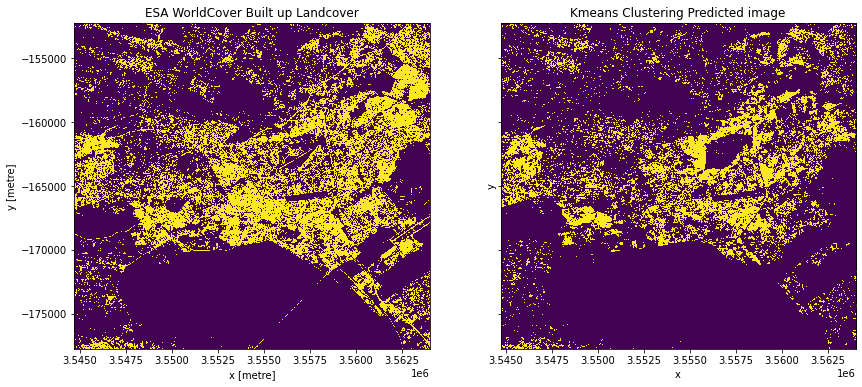

In [20]:
# Plot the built up land cover from the ESA worldcover dataset.
esa_urban_class = 50

built_up = ds_esa["classification"] == esa_urban_class#.classification

fig,ax=plt.subplots(1,2, figsize=(14, 6), sharey=True)
built_up.plot.imshow(ax=ax[0], add_colorbar=False)
clustering_predicted_ds.plot.imshow(ax=ax[1], add_colorbar=False)
ax[1].set_title("Kmeans Clustering Predicted image")
ax[0].set_title("ESA WorldCover Built up Landcover");

### Accuracy assessment metrics
We will use functions from the `sklearn.metrics` module to evaluate the Kmeans clustering classification. 
Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial. 

$$
\begin{aligned}
\text{Overall Accuracy (OA)} = \frac{\text{True Positive} + \text{True Negative}}{\text{Total Pixels}}
\end{aligned}
$$

$$
\begin{aligned}
\text{Producer's Accuracy (PA) or Precision} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Positive}}
\end{aligned}
$$

$$
\begin{aligned}
\text{User's accuracy (UA) or  Recall} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}
\end{aligned}
$$

$$
\begin{aligned}
\text{F1 Score} = 2*\frac{\text{Recall}*\text{Precision}}{\text{Recall} + \text{Precision}}
\end{aligned}
$$


In [21]:
# Metrics for the Kmeans Clustering.
y_true = sklearn_flatten(built_up)
y_pred_kmeans = sklearn_flatten(clustering_predicted_ds)

# Producer's Accuracies.
precision_kmeans = precision_score(y_true, y_pred_kmeans, labels=[0, 1], average=None)
urban_precision_kmeans = precision_kmeans[1] * 100

# User's Accuracies.
recall_kmeans = recall_score(y_true, y_pred_kmeans, labels=[0, 1], average=None)
urban_recall_kmeans = recall_kmeans[1] * 100

# Overall Accuracy.
accuracy_kmeans = accuracy_score(y_true, y_pred_kmeans, normalize=True)
overall_accuracy_kmeans = accuracy_kmeans * 100

# F1 score.
f1score_kmeans = f1_score(y_true, y_pred_kmeans)


In [22]:
print(
    "\033[1m" + "\033[91m" + "Urban Area Mapping using Kmeans Clustering Results"
)  # bold print and red
print("\033[0m")  # stop bold and red
print("Overall Accuracy: ", round(overall_accuracy_kmeans, 2))
print("F1 score: \t", round(f1score_kmeans, 2))
print("Producer's Accuracy: ",
        round(urban_precision_kmeans, 2))
print(
        "User's Accuracy: ",
        round(urban_recall_kmeans, 2),
    )

Urban Area Mapping using Kmeans Clustering Results

Overall Accuracy:  79.29
F1 score: 	 0.53
Producer's Accuracy:  67.28
User's Accuracy:  43.53


The `dstack` calls provide the `imshow` calls with RGB array inputs. 
For the plotted image, the first channel (red) is the actual (ground truth, ESA Worldcover) values, and both the second and third channels (green, blue) are the predicted values (green + blue = cyan).

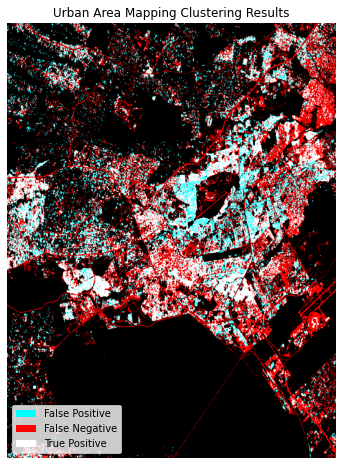

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(
    np.dstack(
        (
            built_up.data.astype(float),
            clustering_predicted_ds.data.astype(float),
            clustering_predicted_ds.data.astype(float),
        )
    )
)
plt.legend(
    [Patch(facecolor="cyan"), Patch(facecolor="red"), Patch(facecolor="white")],
    ["False Positive", "False Negative", "True Positive"],
    loc="lower left",
    fontsize=10,
)
plt.axis("off")
plt.title("Urban Area Mapping Clustering Results");

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [24]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [25]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-12-22'